## **Assignment 2: Zone Level Thermal Analysis**

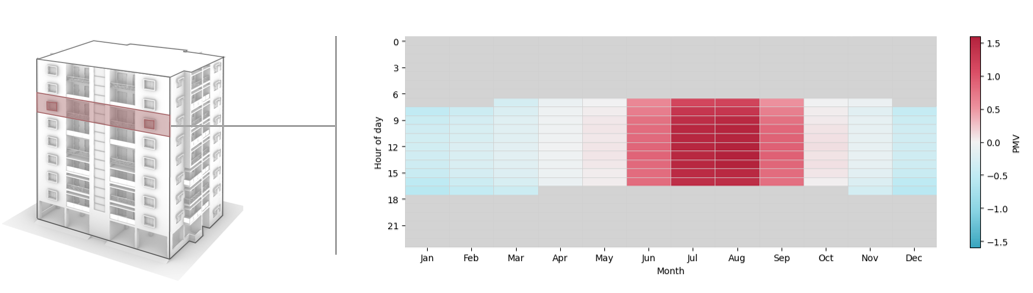

### **This Colab notebook is a guided workflow for assessing indoor environmental conditions using comfort indices (PMV) and temperature exceedance metrics.**

In this notebook, you will work with **two zones** and learn how to:
- **Compute annual PMV** under different assumptions (clothing, met rate, air speed)
- **Optimize comfort** by selecting the clothing level that minimizes discomfort during occupied hours
- **Compare scenarios** and identify which settings reduce heat and cold discomfort
- **Generate an occupancy recommendation** (if you can move between spaces)
- **Go beyond comfort** by analyzing continuous exceedance durations above temperature thresholds



---



# **0.0 Cloning Gitub Repo and Install Dependencies**

In [1]:
# --- 1) Install deps (optional if you already did this) ---
!pip -q install --no-deps "pandas==2.2.2"
!pip -q install -U pythermalcomfort matplotlib numpy

# --- 2) Get your repo into Colab ---
!rm -rf /content/People-Planet-Property
!git clone -q https://github.com/Nadatarkhan/People-Planet-Property.git /content/People-Planet-Property

# --- 3) Add the folder that contains thermal_data_loader.py to Python path ---
import sys
THERMAL_DIR = "/content/People-Planet-Property/Thermal_Analysis"
if THERMAL_DIR not in sys.path:
    sys.path.insert(0, THERMAL_DIR)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 61.3 MB/s eta 0:00:00


# **1.0 Compute Annual PMV based on Clothing level range**

PMV (Predicted Mean Vote) is a standard thermal comfort index that estimates how people *perceive* thermal conditions based on:
- air temperature and radiant temperature
- humidity
- air speed
- metabolic rate (met)
- clothing insulation (clo)

In this workflow, we compute PMV for **occupied hours only**, and then **optimize comfort** by searching over a clothing range you define. For each occupied hour, we select the clothing value that **minimizes PMV**.



# 1.1 Work with Defaults (2 Sample Zones)

Before loading your own data, we start with a **default example** using two sample zones. (optional)

In [2]:
from thermal_data_loader import load_zone_csvs

df_zone1, df_zone2 = load_zone_csvs()
print(df_zone1.shape, df_zone2.shape)
df_zone1.head(), df_zone2.head()

Downloading: https://raw.githubusercontent.com/Nadatarkhan/People-Planet-Property/main/Thermal_Analysis/data/PMV_zone1.csv
Saved to: /content/PMV_zone1.csv
Downloading: https://raw.githubusercontent.com/Nadatarkhan/People-Planet-Property/main/Thermal_Analysis/data/PMV_zone2.csv
Saved to: /content/PMV_zone2.csv
(8760, 12) (8760, 12)


(  ZoneName  Month  Day  Hour       PMV        PPD   CLO  OCC   TDryBulb  \
 0   Zone_1      1    1     0 -1.314423  41.013588  0.75    0  18.055999   
 1   Zone_1      1    1     1 -1.310305  40.799710  0.75    0  18.107923   
 2   Zone_1      1    1     2 -1.319762  41.289375  0.75    0  18.088624   
 3   Zone_1      1    1     3 -1.325923  41.609246  0.75    0  18.072819   
 4   Zone_1      1    1     4 -1.328326  41.734227  0.75    0  18.067630   
 
    TWetBulb        MRT    RelHum  
 0  8.198826  16.111998  0.213901  
 1  8.032604  16.215847  0.200465  
 2  7.864237  16.177248  0.190139  
 3  7.772089  16.145637  0.184717  
 4  7.730777  16.135260  0.182208  ,
   ZoneName  Month  Day  Hour       PMV        PPD   CLO  OCC   TDryBulb  \
 0   Zone_2      1    1     0 -1.314423  41.013588  0.75    0  18.916942   
 1   Zone_2      1    1     1 -1.310305  40.799710  0.75    0  18.803885   
 2   Zone_2      1    1     2 -1.319762  41.289375  0.75    0  19.239575   
 3   Zone_2      1   

# 1.2 Load in Hourly Data from 2 Zones

Here we load the **hourly indoor time series** needed to compute PMV for each zone. When you run the below code, you will be prompted to load 2 files saved locally.

In [ ]:
from thermal_upload_loader import upload_and_load_zone_csvs

rename_map = {
    "zone1.csv": "PMV_zone1.csv",
    "zone2.csv": "PMV_zone2.csv",
}
df_zone1, df_zone2 = upload_and_load_zone_csvs(rename_map=rename_map)

Please upload your two files: PMV_zone1.csv and PMV_zone2.csv


Saving PMV_zone1.csv to PMV_zone1.csv
Saving PMV_zone2.csv to PMV_zone2.csv
Saved: /content/PMV_zone1.csv
Saved: /content/PMV_zone2.csv
Zone 1 shape: (8760, 12) | path: /content/PMV_zone1.csv
Zone 2 shape: (8760, 12) | path: /content/PMV_zone2.csv


,ZoneName,Month,Day,Hour,PMV,PPD,CLO,OCC,TDryBulb,TWetBulb,MRT,RelHum
0,Zone_1,1,1,0,-1.314423,41.013588,0.75,0,18.055999,8.198826,16.111998,0.213901
1,Zone_1,1,1,1,-1.310305,40.799710,0.75,0,18.107923,8.032604,16.215847,0.200465
2,Zone_1,1,1,2,-1.319762,41.289375,0.75,0,18.088624,7.864237,16.177248,0.190139
3,Zone_1,1,1,3,-1.325923,41.609246,0.75,0,18.072819,7.772089,16.145637,0.184717
4,Zone_1,1,1,4,-1.328326,41.734227,0.75,0,18.067630,7.730777,16.135260,0.182208


,ZoneName,Month,Day,Hour,PMV,PPD,CLO,OCC,TDryBulb,TWetBulb,MRT,RelHum
0,Zone_2,1,1,0,-1.314423,41.013588,0.75,0,18.916942,8.198826,16.972941,0.213901
1,Zone_2,1,1,1,-1.310305,40.799710,0.75,0,18.803885,8.032604,16.911808,0.200465
2,Zone_2,1,1,2,-1.319762,41.289375,0.75,0,19.239575,7.864237,17.328199,0.190139
3,Zone_2,1,1,3,-1.325923,41.609246,0.75,0,19.345065,7.772089,17.417884,0.184717
4,Zone_2,1,1,4,-1.328326,41.734227,0.75,0,18.825554,7.730777,16.893184,0.182208


# 1.3 Compute Optimum Clothing Level

In this step we generate a PMV run by applying the clothing optimization rule:

For each occupied hour:
- evaluate PMV across the clothing range you specified (day/night)
- select the clothing value that produces the **minimum absolute PMV**

This produces an annual PMV profile for each zone and a record of the selected clothing value over time.

📁 The resulting runs are saved to `pmv_runs/` so you can compare it against other runs later.

In [3]:
from thermal_clo_optimizer import launch_clothing_optimizer_ui
launch_clothing_optimizer_ui()  # reads /content/PMV_zone1.csv and /content/PMV_zone2.csv

# **2.0 Plot PMV Runs**

This section helps you interpret and compare PMV outcomes across scenarios.

We visualize:
- PMV distributions across the year
- hot vs cold discomfort hours
- how different assumptions (clothing ranges, met, air speed) change outcomes

# 2.1 Compare Hot and Cold hours across runs across all zones

Across the two zones, here we compare multiple saved runs to investigate how scenarios compare to each other.

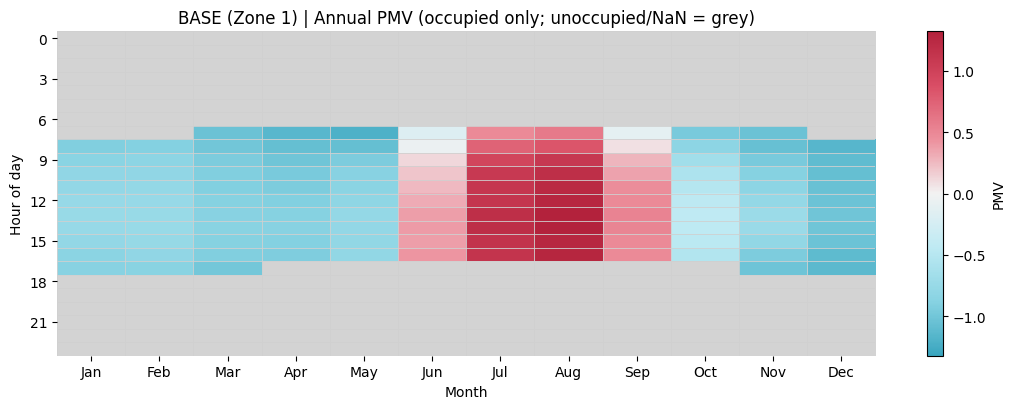

BASE (Zone 1)
Clothing column used: CLO
Avg DAY clothing (whole year):   0.652
Avg NIGHT clothing (whole year): 0.652
Hot hours  (PMV >= +1.0): 474
Cold hours (PMV <= -1.0): 885
Computable occupied rows used for hot/cold counts: 3650
--------------------------------------------------------------------------------


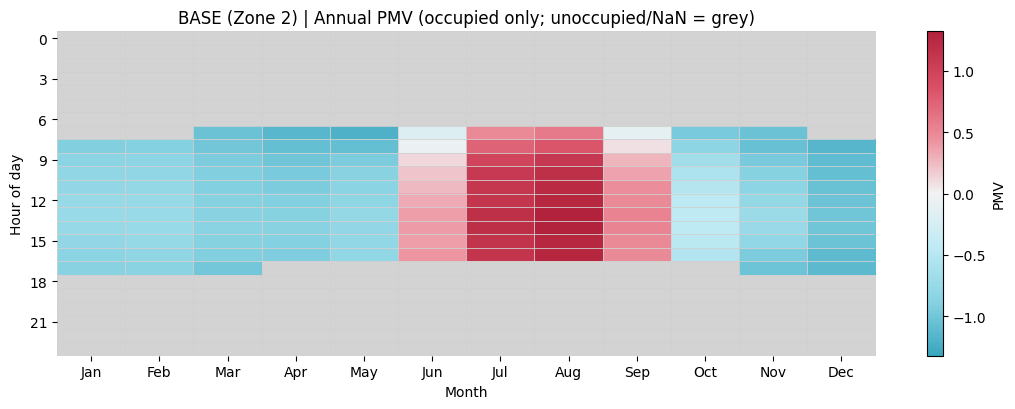

BASE (Zone 2)
Clothing column used: CLO
Avg DAY clothing (whole year):   0.652
Avg NIGHT clothing (whole year): 0.652
Hot hours  (PMV >= +1.0): 474
Cold hours (PMV <= -1.0): 885
Computable occupied rows used for hot/cold counts: 3650
--------------------------------------------------------------------------------


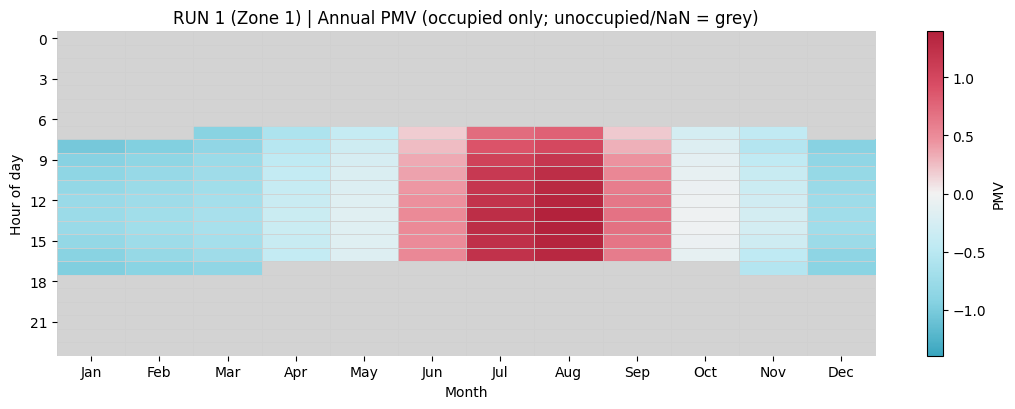

RUN 1 (Zone 1)
Clothing column used: clo_used
Avg DAY clothing (whole year):   0.957
Avg NIGHT clothing (whole year): N/A (no night samples)
Hot hours  (PMV >= +1.0): 491
Cold hours (PMV <= -1.0): 178
Computable occupied rows used for hot/cold counts: 3650
--------------------------------------------------------------------------------


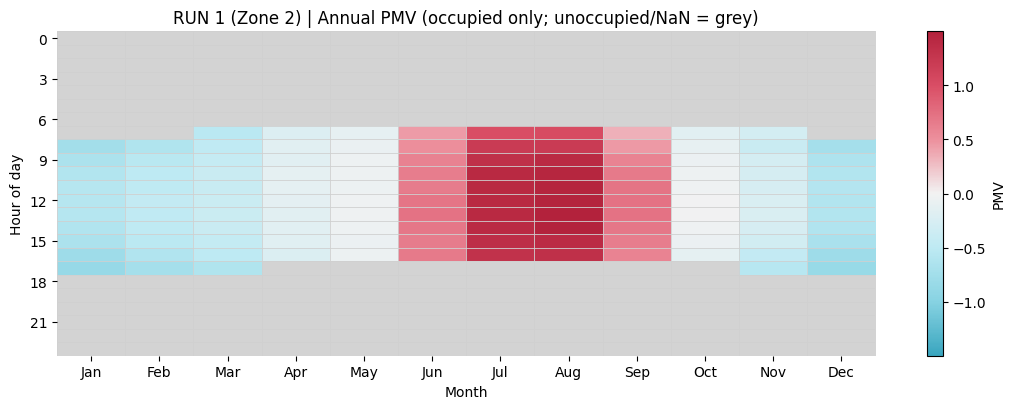

RUN 1 (Zone 2)
Clothing column used: clo_used
Avg DAY clothing (whole year):   0.940
Avg NIGHT clothing (whole year): N/A (no night samples)
Hot hours  (PMV >= +1.0): 594
Cold hours (PMV <= -1.0): 30
Computable occupied rows used for hot/cold counts: 3650
--------------------------------------------------------------------------------


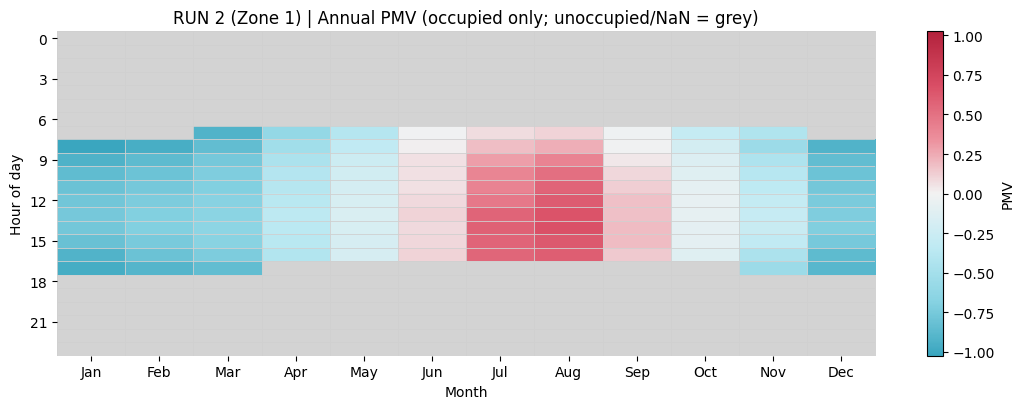

RUN 2 (Zone 1)
Clothing column used: clo_used
Avg DAY clothing (whole year):   0.831
Avg NIGHT clothing (whole year): N/A (no night samples)
Hot hours  (PMV >= +1.0): 127
Cold hours (PMV <= -1.0): 178
Computable occupied rows used for hot/cold counts: 3650
--------------------------------------------------------------------------------


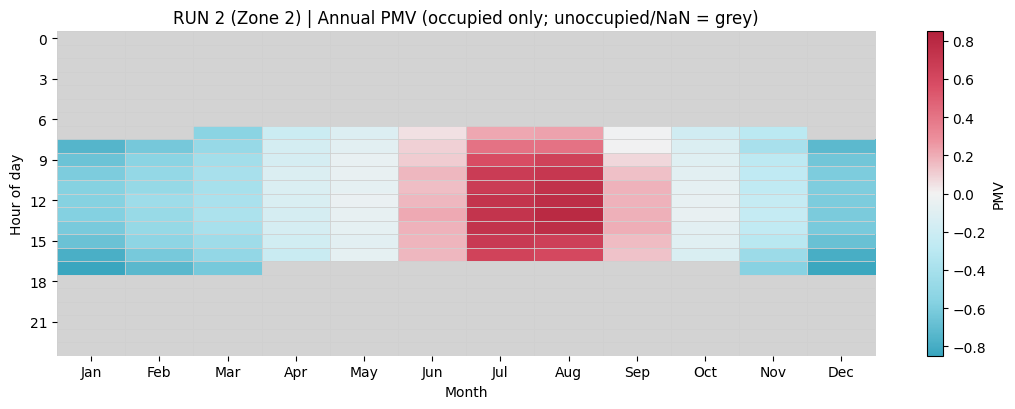

RUN 2 (Zone 2)
Clothing column used: clo_used
Avg DAY clothing (whole year):   0.796
Avg NIGHT clothing (whole year): N/A (no night samples)
Hot hours  (PMV >= +1.0): 212
Cold hours (PMV <= -1.0): 30
Computable occupied rows used for hot/cold counts: 3650
--------------------------------------------------------------------------------


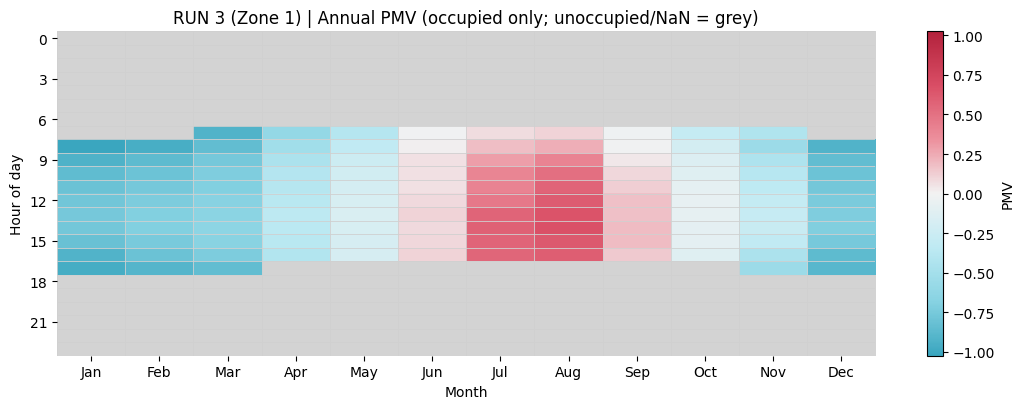

RUN 3 (Zone 1)
Clothing column used: clo_used
Avg DAY clothing (whole year):   0.831
Avg NIGHT clothing (whole year): N/A (no night samples)
Hot hours  (PMV >= +1.0): 127
Cold hours (PMV <= -1.0): 178
Computable occupied rows used for hot/cold counts: 3650
--------------------------------------------------------------------------------


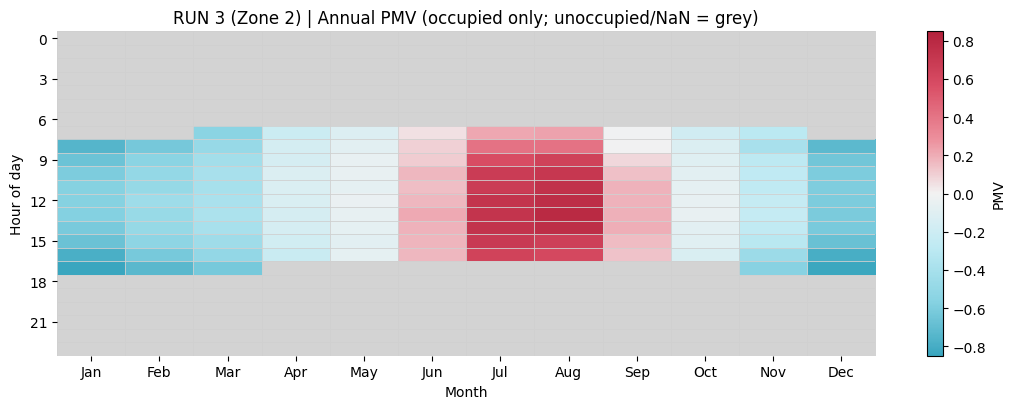

RUN 3 (Zone 2)
Clothing column used: clo_used
Avg DAY clothing (whole year):   0.796
Avg NIGHT clothing (whole year): N/A (no night samples)
Hot hours  (PMV >= +1.0): 212
Cold hours (PMV <= -1.0): 30
Computable occupied rows used for hot/cold counts: 3650
--------------------------------------------------------------------------------


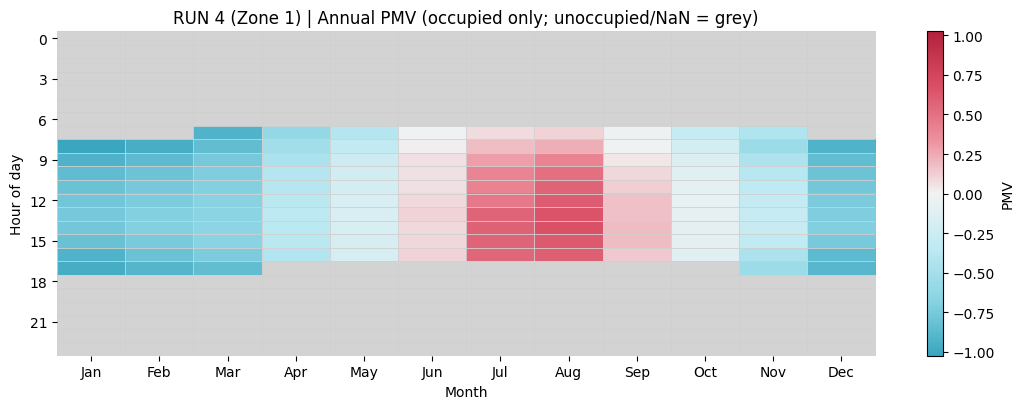

RUN 4 (Zone 1)
Clothing column used: clo_used
Avg DAY clothing (whole year):   0.831
Avg NIGHT clothing (whole year): N/A (no night samples)
Hot hours  (PMV >= +1.0): 127
Cold hours (PMV <= -1.0): 178
Computable occupied rows used for hot/cold counts: 3650
--------------------------------------------------------------------------------


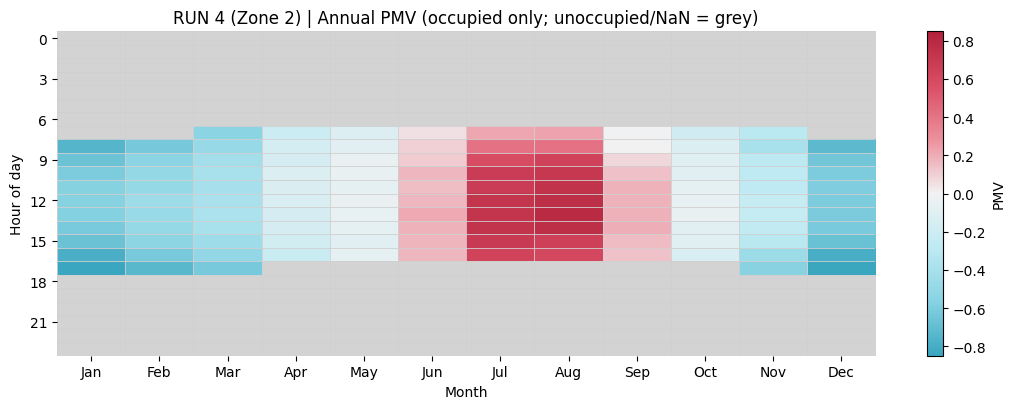

RUN 4 (Zone 2)
Clothing column used: clo_used
Avg DAY clothing (whole year):   0.796
Avg NIGHT clothing (whole year): N/A (no night samples)
Hot hours  (PMV >= +1.0): 212
Cold hours (PMV <= -1.0): 30
Computable occupied rows used for hot/cold counts: 3650
--------------------------------------------------------------------------------


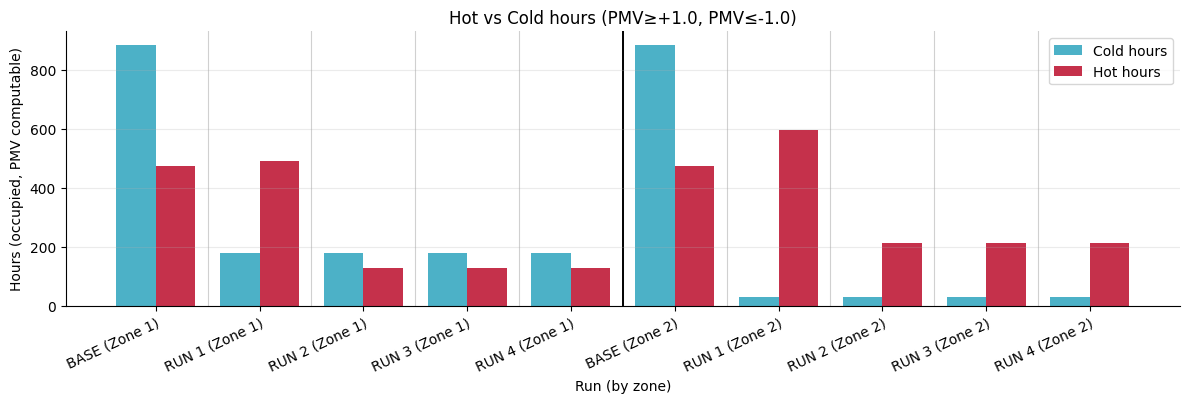

In [4]:
from thermal_pmv_review_plots import plot_all_base_and_runs
plot_all_base_and_runs()

# 2.2 Save best run (the one that minimizes discomfort hours across both zones)

Now we select the “best” run based on the run that minimizes total discomfort hours across both zones.

The chosen run becomes your baseline for the next parts of the notebook

📁 We save the selected outputs to `Chosen_scenario/`

In [5]:
from thermal_choose_best_scenario import pick_best_paired_run_min_discomfort
pick_best_paired_run_min_discomfort()

✅ Chosen paired scenario (same run number for both zones): run_002
Validity gate (anti-empty): computable OCC rows per zone >= 24
Computable occupied rows: Zone 1 = 3650, Zone 2 = 3650
Discomfort hours definition: OCC==1 & finite PMV & (PMV>+1.0 OR PMV<-1.0)
Zone 1 discomfort hours: 279
Zone 2 discomfort hours: 235
TOTAL discomfort hours (Zone1+Zone2): 514
Saved to:
  - /content/Chosen_scenario/run_002_Zone_1.csv
  - /content/Chosen_scenario/run_002_Zone_2.csv


{'run_id': 2,
 'zone1_path': '/content/Chosen_scenario/run_002_Zone_1.csv',
 'zone2_path': '/content/Chosen_scenario/run_002_Zone_2.csv',
 'total_discomfort_hours': 514,
 'zone1_computable_occ_rows': 3650,
 'zone2_computable_occ_rows': 3650,
 'pmv_hot_thr': 1.0,
 'pmv_cold_thr': -1.0,
 'min_computable_occ_rows_per_zone': 24}

# **3.0 Occupancy Recommednation- Across 2 Zones**

Here we can investigate how occupancy across the two zones can reduce aggregate discomfort.

We generate an **optimized occupancy recommendation** by comparing Zone 1 vs Zone 2 for each hour of the year and selecting the zone with the lower mean PMV.

This produces a year-round “where to be” schedule across the year and the respective clothing level.

📁 The combined schedule is saved to `Chosen_scenario/`.

/content/People-Planet-Property/Thermal_Analysis/thermal_chosen_maps.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


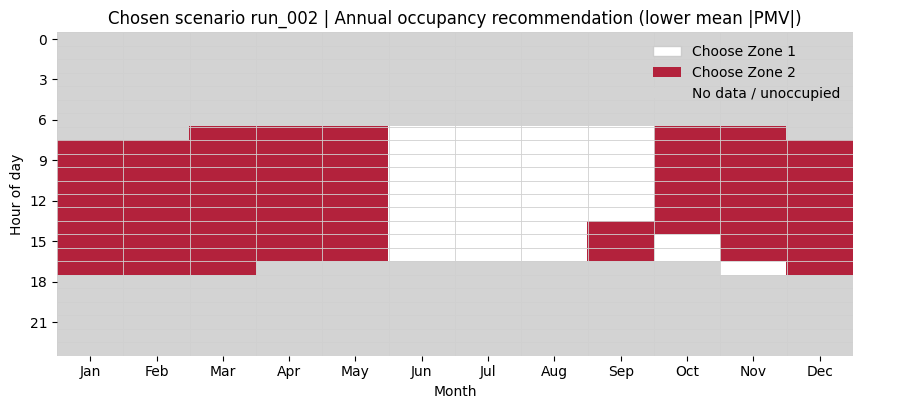

✅ Saved combined CSV: /content/Chosen_scenario/run_002_combined.csv


/content/People-Planet-Property/Thermal_Analysis/thermal_chosen_maps.py:267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


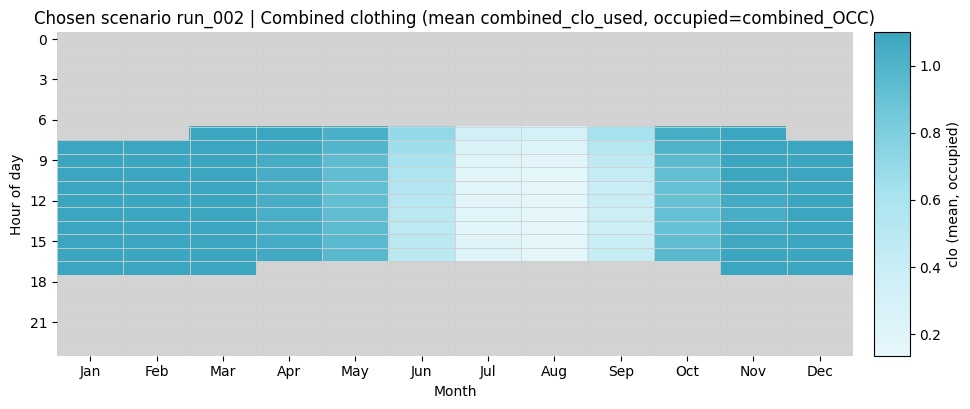

Combined CSV at: /content/Chosen_scenario/run_002_combined.csv


In [6]:
import sys
sys.path.append("/content/thermal")

from thermal_chosen_maps import plot_chosen_annual_zone_occupancy_map_and_plot_combined_clothing
combined_path = plot_chosen_annual_zone_occupancy_map_and_plot_combined_clothing("/content/Chosen_scenario")
print("Combined CSV at:", combined_path)

# **4.0 Beyond Comfort**

PMV captures perceived comfort, but risk assessment often requires threshold-based metrics.

In this section, we analyze **temperature exceedance**, focusing on hours above defined temperature thresholds and **continuous exposure durations**

You can set your own thresholds based on predefined metrics or ones you explore depending on the use case!

In [9]:
import sys

THERMAL_DIR = "/content/People-Planet-Property/Thermal_Analysis"
sys.path.insert(0, THERMAL_DIR)

import thermal_threshold_events_ui as ui
ui.launch_threshold_ui(chosen_dir="/content/Chosen_scenario");


# **Save out Zone Runs**

In [8]:
# Zip + download the two folders: Chosen_scenario and pmv_runs

import os, shutil
from google.colab import files

def zip_and_download(folder_path):
    folder_path = os.path.abspath(folder_path)
    if not os.path.isdir(folder_path):
        raise RuntimeError(f"Folder not found: {folder_path}")

    base_name = os.path.basename(folder_path.rstrip("/"))
    zip_base = os.path.join("/content", base_name)  # .zip will be added
    zip_path = shutil.make_archive(zip_base, "zip", root_dir=folder_path)

    print("✅ Zipped:", zip_path)
    files.download(zip_path)

zip_and_download("/content/Chosen_scenario")
zip_and_download("/content/pmv_runs")


✅ Zipped: /content/Chosen_scenario.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Zipped: /content/pmv_runs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Save to Drive

In [10]:
from google.colab import drive

# 1) Mount Drive
drive.mount("/content/drive")

# 2) Choose where in Drive to save
DRIVE_DEST_ROOT = "/content/drive/MyDrive/People-Planet-Property/Assignment_2_outputs"

folders_to_save = {
    "Chosen_scenario": "/content/Chosen_scenario",
    "pmv_runs": "/content/pmv_runs",
}

os.makedirs(DRIVE_DEST_ROOT, exist_ok=True)

for name, src in folders_to_save.items():
    if not os.path.isdir(src):
        print(f"⚠️ Skipping (not found): {src}")
        continue

    dst = os.path.join(DRIVE_DEST_ROOT, name)

    if os.path.exists(dst):
        shutil.rmtree(dst)

    shutil.copytree(src, dst)
    print(f"✅ Saved to Drive: {dst}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved to Drive: /content/drive/MyDrive/People-Planet-Property/Assignment_2_outputs/Chosen_scenario
✅ Saved to Drive: /content/drive/MyDrive/People-Planet-Property/Assignment_2_outputs/pmv_runs
